https://www.kaggle.com/rautaki0127/pokemon-data-science-challenge/notebook

ポケモンの勝敗予測の問題をやってみる。

提供されるCSV

- pokemon.csv
 - ポケモンの属性表
- combats.csv
 - 過去のポケモンの勝敗
- tests.csv
 - 勝敗予測するポケモンの組み合わせ

In [3]:
import pandas as pd
# 基本的にcsvは最初にpandasのDataframeにしている
combats = pd.read_csv('./input/combats.csv')
combats.head(3)

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668


In [4]:
pokemon = pd.read_csv('./input/pokemon.csv')
pokemon_266_298 = pokemon[pokemon['#'].isin([266, 298])]
pokemon_266_298

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
265,266,Larvitar,Rock,Ground,50,64,50,45,50,41,2,False
297,298,Nuzleaf,Grass,Dark,70,70,40,60,40,60,3,False


In [5]:
tests = pd.read_csv('./input/tests.csv')
tests.head(3)

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115


In [6]:
a = dict()
type(a)

dict

In [7]:
# zip ２つのリストをとって、両方の要素を持つタプルを作りそのリストを返す
# dict タプルのリストを辞書にする
# 結果names_dictはポケモンのidをキーにして、ポケモンの名前が取れる
names_dict = dict(zip(pokemon['#'], pokemon['Name']))
cols = ["First_pokemon","Second_pokemon","Winner"]
combats_name = combats[cols].replace(names_dict)
combats_name.head(3)

,First_pokemon,Second_pokemon,Winner
0,Larvitar,Nuzleaf,Nuzleaf
1,Virizion,Terrakion,Terrakion
2,Togetic,Beheeyem,Beheeyem


最初はざっくりした傾向を見るところから始める。

ポケモンの属性値を足し合わせた数値でヒストグラムを作ってみる。
- 合計のポケモンの数は８００
- 300と500の周辺に分布している

count    800.00000
mean     435.10250
std      119.96304
min      180.00000
25%      330.00000
50%      450.00000
75%      515.00000
max      780.00000
Name: stats_sum, dtype: float64


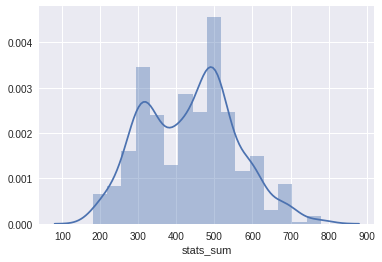

In [8]:
pokemon["stats_sum"] = pokemon["HP"] + pokemon["Attack"] + pokemon["Defense"] + pokemon["Sp. Atk"] + pokemon["Sp. Def"] + pokemon["Speed"]
# matoplotlib はグラフ描画のライブラリ
# seabornはmatoplotlibのラッパーみたいなもの
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# pandas.DataFrame.describeでdataframeの概要を出力
print(pokemon["stats_sum"].describe())
# 値の分布を示すヒストグラム
sns.distplot(pokemon["stats_sum"])
plt.show()

勝敗の履歴の分析
- 50000バトルの情報がある
- 勝負の時にポケモン同士の性能差がどのくらいあるか

count    50000.000000
mean       136.551440
std        101.221212
min          0.000000
25%         54.000000
50%        118.000000
75%        200.000000
max        590.000000
dtype: float64


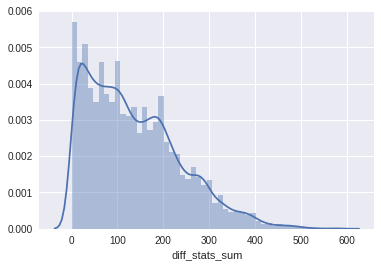

In [9]:
# stat_sum_dict ポケモンのIDをキーに、ポケモンの基本性能値を値に持つ辞書
stats_sum_dict = dict(zip(pokemon['#'], pokemon['stats_sum']))
combats_stats_sum = combats[cols].replace(stats_sum_dict)
# abs は絶対値 diff_stats_sumには勝負ごとにポケモンの基本性能差がどのくらいだったかが入る
diff_stats_sum = abs(combats_stats_sum["First_pokemon"]-combats_stats_sum["Second_pokemon"])
print(diff_stats_sum.describe())
sns.distplot(diff_stats_sum)
plt.xlabel("diff_stats_sum")
plt.show()

ポケモンの勝率は一様ではないので、何らかの因子によって勝ちやすいポケモンがいることになる
まず、基本性能がいいポケモンが勝つ可能性を検討する

結果としては、性能が高いポケモンが勝つ傾向にある

count    50000.000000
mean        79.776320
std        150.093351
min       -562.000000
25%        -20.000000
50%         80.000000
75%        186.000000
max        590.000000
dtype: float64


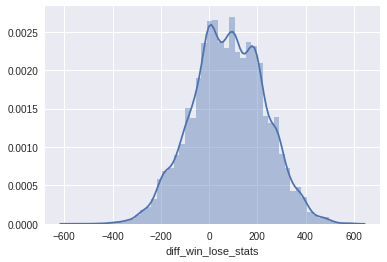

In [10]:
# applyでdataframeの各行に関数を適用する
combats_stats_sum["Loser"] = combats_stats_sum.apply(lambda x: x["First_pokemon"] if x["First_pokemon"] !=  x["Winner"] else x["Second_pokemon"], axis = 1)
# 勝ったポケモンと負けたポケモンの性能差を集計する
diff_win_lose_stats = combats_stats_sum["Winner"] - combats_stats_sum["Loser"]
print(diff_win_lose_stats.describe())
sns.distplot(diff_win_lose_stats)
plt.xlabel("diff_win_lose_stats")
plt.show()

より基本性能の高いポケモンが勝つという仮説に対して、より基本性能が低いポケモンが勝ったらケースを確認してみる
- 5000を超えるケースで、100ポイント以上基本性能が下回るポケモンが勝利している

In [11]:
# ポケモンの基本性能をキーにしてポケモンのidを引く辞書
stats_sum_dict_re = dict(zip(pokemon['stats_sum'], pokemon['#']))
# ポケモンの勝敗表に性能差の列をつける
combats_stats_sum["diff"] = diff_win_lose_stats
# 基本性能が100以上下回るポケモンが勝った例を集める
surpassing_stats_sum = combats_stats_sum[combats_stats_sum["diff"] < -100]
surpassing_stats_sum.head(3)

,First_pokemon,Second_pokemon,Winner,Loser,diff
5,319,520,319,520,-201
36,348,240,240,348,-108
37,330,455,330,455,-125


In [12]:
print ("Surpassing one's superiors Battle number : " + str(len(surpassing_stats_sum)))
surpassing_id = surpassing_stats_sum[cols].replace(stats_sum_dict_re)
surpassing_name = surpassing_id[cols].replace(names_dict)
surpassing_name.join(combats_stats_sum["diff"]).head(8)

Surpassing one's superiors Battle number : 5716


,First_pokemon,Second_pokemon,Winner,diff
5,Joltik,Aegislash Shield Forme,Joltik,-201
36,Pancham,Whismur,Whismur,-108
37,Clauncher,Dusclops,Clauncher,-125
42,Goomy,Bouffalant,Goomy,-190
51,Mega Rayquaza,Aegislash Shield Forme,Aegislash Shield Forme,-260
158,Bouffalant,Vullaby,Vullaby,-120
168,Keldeo Resolute Forme,Arbok,Arbok,-142
174,Gothorita,Volcanion,Gothorita,-210


特に代表的な、基本性能が下のポケモンが勝つ組み合わせ

In [13]:
surpassing_name.join(combats_stats_sum["diff"]).sort_values(by="diff").head(4)

,First_pokemon,Second_pokemon,Winner,diff
5861,Mega Rayquaza,Cleffa,Cleffa,-562
2480,Mega Rayquaza,Cleffa,Cleffa,-562
41824,Shedinja,Mega Rayquaza,Shedinja,-544
3506,Mega Rayquaza,Inkay,Inkay,-492


より弱いポケモンが勝つ理由について仮説を立てる
- 先攻が勝っているのではないか
- ポケモンの属性によって勝っているのではないか

※ここでドメインの知識があればたくさん精度の高い仮説が出せるんだろうなって感じがする。
いい仮説がたくさん出せればうまくいけば機械学習の工程がほぼ検証作業にできるわけで圧倒的に効率がいい

まず先攻の勝率と負け率を比べてみる。
結果あまり差はみられない

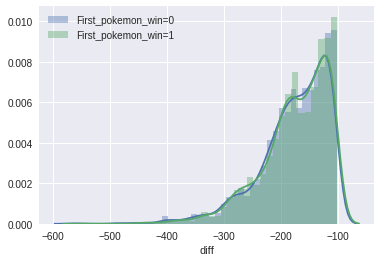

In [14]:
combats_stats_sum["First_Win"] =  combats_stats_sum.apply(lambda x: 1 if x["First_pokemon"] ==  x["Winner"] else 0, axis = 1)
surpassing_stats_sum = combats_stats_sum[combats_stats_sum["diff"] < -100]
sns.distplot(surpassing_stats_sum[surpassing_stats_sum["First_Win"]==0]["diff"], label="First_pokemon_win=0")
sns.distplot(surpassing_stats_sum[surpassing_stats_sum["First_Win"]==1]["diff"], label="First_pokemon_win=1")
plt.legend()
plt.show()

-First_Win=0-
count    26065.000000
mean        76.155764
std        152.292707
min       -562.000000
25%        -27.000000
50%         79.000000
75%        185.000000
max        585.000000
Name: diff, dtype: float64
-First_Win=1-
count    23935.000000
mean        83.719072
std        147.563182
min       -544.000000
25%        -13.000000
50%         82.000000
75%        190.000000
max        590.000000
Name: diff, dtype: float64


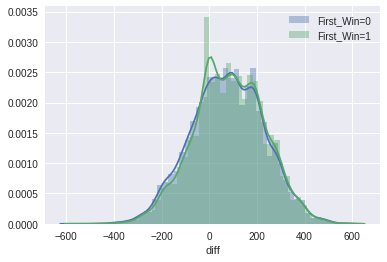

In [15]:
sns.distplot(combats_stats_sum[combats_stats_sum["First_Win"]==0]["diff"], label="First_Win=0")
sns.distplot(combats_stats_sum[combats_stats_sum["First_Win"]==1]["diff"], label="First_Win=1")
print ("-First_Win=0-")
print (combats_stats_sum[combats_stats_sum["First_Win"]==0]["diff"].describe())
print ("-First_Win=1-")
print (combats_stats_sum[combats_stats_sum["First_Win"]==1]["diff"].describe())
plt.legend()
plt.show()

結局差がないので、先攻が有利という仮説は誤りに見える。
次にポケモンの属性を確認する。

In [16]:
print ("There are {} Types.".format(len(pokemon["Type 1"].drop_duplicates())))
list(pokemon["Type 1"].drop_duplicates())

There are 18 Types.


['Grass',
 'Fire',
 'Water',
 'Bug',
 'Normal',
 'Poison',
 'Electric',
 'Ground',
 'Fairy',
 'Fighting',
 'Psychic',
 'Rock',
 'Ghost',
 'Ice',
 'Dragon',
 'Dark',
 'Steel',
 'Flying']

ポケモンのぞくせいは２つ持てるので、組み合わせを見る

In [17]:
type_cols = ["Type 1", "Type 2"]
print ("There are {} unique type-combinations.".format(len(pokemon[type_cols].drop_duplicates())))

There are 154 unique type-combinations.


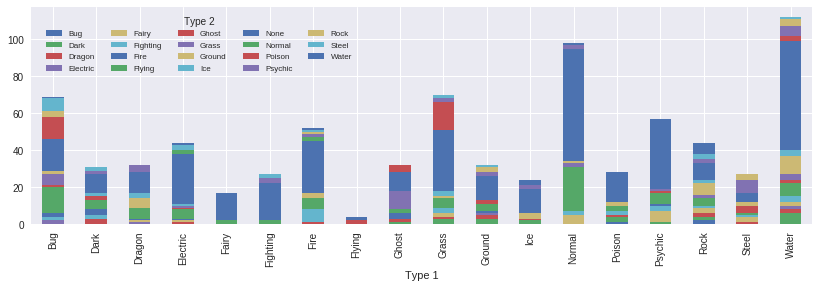

In [18]:
pokemon["Type 2"] = pokemon["Type 2"].fillna("None")
type_cross = pd.crosstab(pokemon["Type 1"], pokemon["Type 2"])
type_cross.plot.bar(stacked=True, figsize=(14,4))
plt.legend(bbox_to_anchor=(0.01, 0.99), loc='upper left', ncol=5, fontsize=8, title="Type 2")
plt.show()

ぞくせいの相性の表を作る。
攻撃側のぞくせいと攻撃を受ける側のぞくせいによってダメージに乗る係数を入れる

In [19]:
Normal = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 0.5, "Ghost": 0, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Fighting = {"Normal": 2, "Fighting": 1, "Poison": 0.5, "Ground": 1, "Flying": 0.5, "Bug": 0.5, "Rock": 2, "Ghost": 0, "Steel": 2, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 2, "Psychic": 0.5, "Dragon": 1, "Dark": 2, "Fairy": 0.5}
Poison = {"Normal": 1, "Fighting": 1, "Poison": 0.5, "Ground": 0.5, "Flying": 1, "Bug": 1, "Rock": 0.5, "Ghost": 0.5, "Steel": 0, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 2, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 2}
Ground = {"Normal": 1, "Fighting": 1, "Poison": 2, "Ground": 1, "Flying": 0, "Bug": 0.5, "Rock": 2, "Ghost": 1, "Steel": 2, "Fire": 2, "Water": 1, "Electric": 2, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Flying = {"Normal": 1, "Fighting": 2, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 2, "Rock": 0.5, "Ghost": 1, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 0.5, "Grass": 2, "Ice": 1, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Bug = {"Normal": 1, "Fighting": 0.5, "Poison": 0.5, "Ground": 1, "Flying": 0.5, "Bug": 1, "Rock": 1, "Ghost": 0.5, "Steel": 0.5, "Fire": 0.5, "Water": 1, "Electric": 1, "Grass": 2, "Ice": 1, "Psychic": 2, "Dragon": 1, "Dark": 2, "Fairy": 0.5}
Rock = {"Normal": 1, "Fighting": 0.5, "Poison": 1, "Ground": 0.5, "Flying": 2, "Bug": 2, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 2, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 2, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 1}
Ghost = {"Normal": 0, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 2, "Steel": 1, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 2, "Dragon": 1, "Dark": 0.5, "Fairy": 1}
Steel = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 2, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 0.5, "Electric": 0.5, "Grass": 1, "Ice": 2, "Psychic": 1, "Dragon": 1, "Dark": 1, "Fairy": 0.5}
Fire = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 2, "Rock": 0.5, "Ghost": 1, "Steel": 2, "Fire": 0.5, "Water": 0.5, "Electric": 1, "Grass": 2, "Ice": 2, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Water = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 2, "Flying": 1, "Bug": 1, "Rock": 2, "Ghost": 1, "Steel": 1, "Fire": 2, "Water": 0.5, "Electric": 1, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Electric = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 0, "Flying": 2, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 1, "Fire": 1, "Water": 2, "Electric": 0.5, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Grass = {"Normal": 1, "Fighting": 1, "Poison": 0.5, "Ground": 2, "Flying": 0.5, "Bug": 0.5, "Rock": 2, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 2, "Electric": 1, "Grass": 0.5, "Ice": 1, "Psychic": 1, "Dragon": 0.5, "Dark": 1, "Fairy": 1}
Ice = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 2, "Flying": 2, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 0.5, "Electric": 1, "Grass": 2, "Ice": 0.5, "Psychic": 1, "Dragon": 2, "Dark": 1, "Fairy": 1}
Psychic = {"Normal": 1, "Fighting": 1, "Poison": 2, "Ground": 2, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 0.5, "Dragon": 1, "Dark": 0, "Fairy": 1}
Dragon = {"Normal": 1, "Fighting": 1, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 1, "Dragon": 2, "Dark": 1, "Fairy": 0}
Dark = {"Normal": 1, "Fighting": 0.5, "Poison": 1, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 2, "Steel": 1, "Fire": 1, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 2, "Dragon": 1, "Dark": 0.5, "Fairy": 0.5}
Fairy = {"Normal": 1, "Fighting": 2, "Poison": 0.5, "Ground": 1, "Flying": 1, "Bug": 1, "Rock": 1, "Ghost": 1, "Steel": 0.5, "Fire": 0.5, "Water": 1, "Electric": 1, "Grass": 1, "Ice": 1, "Psychic": 1, "Dragon": 2, "Dark": 2, "Fairy": 1}

type_relation = {"Normal": Normal, "Fighting": Fighting, "Poison": Poison, "Ground": Ground, "Flying": Flying, "Bug": Bug, "Rock": Rock, "Ghost": Ghost, "Steel": Steel, "Fire": Fire, "Water": Water, "Electric": Electric, "Grass": Grass, "Ice": Ice, "Psychic": Psychic, "Dragon": Dragon, "Dark": Dark, "Fairy": Fairy}
df_type_relation = pd.DataFrame(type_relation)
print ("Row is Diffender, Column is Attacker")
df_type_relation

Row is Diffender, Column is Attacker


,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Bug,1.0,1.0,1.0,1.0,1.0,0.5,2.0,2.0,1.0,0.5,0.5,1.0,1.0,1.0,1.0,2.0,1.0,1.0
Dark,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Dragon,1.0,1.0,2.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.5
Electric,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
Fairy,0.5,0.5,0.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.5,1.0
Fighting,0.5,0.5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0
Fire,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0
Flying,0.5,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0,0.5,0.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
Ghost,0.5,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.5,1.0,1.0,1.0,1.0
Grass,2.0,1.0,1.0,0.5,1.0,1.0,2.0,2.0,1.0,0.5,0.5,2.0,1.0,2.0,1.0,1.0,1.0,0.5


ぞくせいごとの勝率のばらつきを見てる？

count    50000.000000
mean         1.146062
std          0.869392
min          0.031250
25%          0.500000
50%          1.000000
75%          1.000000
max         16.000000
Name: Relation, dtype: float64


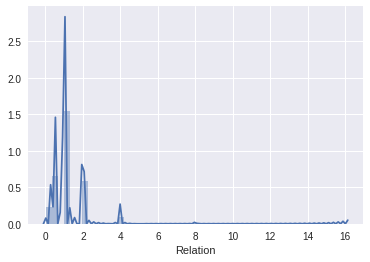

In [20]:
pokemon["Type"] = pokemon.apply(lambda x: x["Type 1"]+"/"+x["Type 2"], axis=1)
type_dict = dict(zip(pokemon['#'], pokemon['Type']))
combats_type = combats[cols].replace(type_dict)
combats_type["Loser"] = combats_type.apply(lambda x: x["First_pokemon"] if x["First_pokemon"] !=  x["Winner"] else x["Second_pokemon"], axis = 1)

zero_dict = {0: 0.25}
df_type_relation = df_type_relation[:].replace(zero_dict)

def calcRelation(combats_type):
    r0 = 1
    win_type1 = combats_type["Winner"].split("/")[0]
    win_type2 = combats_type["Winner"].split("/")[1]
    lose_type1 = combats_type["Loser"].split("/")[0]
    lose_type2 = combats_type["Loser"].split("/")[1]
    if win_type2 != "None" and lose_type2 != "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r2 = df_type_relation[win_type1][lose_type2]
        r3 = df_type_relation[win_type2][lose_type1]
        r4 = df_type_relation[win_type2][lose_type2]
        r = r0 * r1 * r2 * r3 * r4
    elif win_type2 != "None" and lose_type2 == "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r3 = df_type_relation[win_type2][lose_type1]
        r = r0 * r1 * r3
    elif win_type2 == "None" and lose_type2 != "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r2 = df_type_relation[win_type1][lose_type2]
        r = r0 * r1 * r2
    elif win_type2 == "None" and lose_type2 == "None":
        r1 = df_type_relation[win_type1][lose_type1]
        r = r0 * r1
    return r

combats_type["Relation"] = combats_type.apply(lambda x: calcRelation(x), axis = 1)
print (combats_type["Relation"].describe())
sns.distplot(combats_type["Relation"])
plt.show()

属性によるダメージ補正の平均は1.1ぐらいなので、これだけで勝ち負けが決まっているわけではない（のか？）

勝ちが多いポケモンを探す
winnerに出ている数が多いポケモンを図示する

In [23]:
import numpy as np
#from wordcloud import WordCloud, ImageColorGenerator
#from PIL import Image

combats_names = combats[cols].replace(names_dict)
print (combats_names["Winner"].value_counts()[:10])
winners = list(combats_names["Winner"])
winners_str = [str(i) for i in winners]
winners_text = (",").join(winners_str)

Mewtwo                152
Aerodactyl            136
Infernape             136
Jirachi               134
Slaking               133
Deoxys Speed Forme    133
Murkrow               130
Mega Absol            130
Mega Houndoom         128
Mega Aerodactyl       127
Name: Winner, dtype: int64


In [21]:
wc = WordCloud(background_color= "black", random_state=1, margin=3).generate(winners_text)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [24]:
first_num = combats_names["First_pokemon"].value_counts()
second_num = combats_names["Second_pokemon"].value_counts()
battle_num = first_num + second_num
battle_win = pd.DataFrame({"battle": battle_num, "win": combats_names["Winner"].value_counts()}, columns=["battle", "win"])
battle_win["ratio"] = battle_win["win"]/battle_win["battle"]
battle_win.sort_values(by=["ratio"], ascending=False).head(10)


,battle,win,ratio
Mega Aerodactyl,129,127.0,0.984496
Weavile,119,116.0,0.974790
Tornadus Therian Forme,125,121.0,0.968000
Mega Beedrill,119,115.0,0.966387
Aerodactyl,141,136.0,0.964539
Mega Lopunny,129,124.0,0.961240
Greninja,127,122.0,0.960630
Meloetta Pirouette Forme,123,118.0,0.959350
Mega Mewtwo Y,125,119.0,0.952000
Mega Sharpedo,120,114.0,0.950000


よく勝っているポケモンの上位１０はこれ

データクレンジング、予測

ポケモンのデータを見ると勝敗表に全ポケモンが載っていないことがわかる
（全ポケモン数は８００だった）
つまり一度も戦ってないポケモンがいる

In [25]:
battle_win.info()

<class 'pandas.core.frame.DataFrame'>
Index: 783 entries, Abomasnow to Zygarde Half Forme
Data columns (total 3 columns):
battle    783 non-null int64
win       782 non-null float64
ratio     782 non-null float64
dtypes: float64(2), int64(1)
memory usage: 24.5+ KB


あと一度も勝っていないので勝率が出ていないポケモンがいる

In [26]:
battle_win[battle_win["win"].isnull()]

,battle,win,ratio
Shuckle,135,NaN,NaN


In [27]:
# win,ratio の NaN を 0.0にする（ポケモンのShuckleに対してやる）
battle_win.loc["Shuckle", ["win", "ratio"]] = 0
battle_win[battle_win.index=="Shuckle"]

,battle,win,ratio
Shuckle,135,0.0,0.0


一度も戦っていないポケモンに対する処理

In [28]:
id_dict = dict(zip(pokemon['Name'], pokemon['#']))
battle_win["Name"] = battle_win.index
battle_win["#"] = battle_win["Name"].replace(id_dict)
ratio_dict = dict(zip(battle_win['#'], battle_win['ratio']))
pokemon["ratio"] = pokemon["#"].replace(ratio_dict)
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,stats_sum,Type,ratio
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318,Grass/Poison,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405,Grass/Poison,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525,Grass/Poison,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625,Grass/Poison,0.560000
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,309,Fire/None,0.491071


In [29]:
nobattle_pokemon = pokemon[pokemon["ratio"]>1]
print ("There are {} pokemons have NaN ratio.".format(len(nobattle_pokemon.index)))
nobattle_pokemon[["#", "Name", "ratio"]]

There are 17 pokemons have NaN ratio.


,#,Name,ratio
11,12,Blastoise,12.0
32,33,Sandshrew,33.0
45,46,Wigglytuff,46.0
62,63,NaN,63.0
65,66,Poliwag,66.0
77,78,Victreebel,78.0
89,90,Magneton,90.0
143,144,Ditto,144.0
182,183,Ariados,183.0
235,236,Ursaring,236.0
